In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import re
from datetime import datetime,timedelta
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import traceback
import itertools
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
import pytz
import statsmodels.api as sm
import warnings
from sklearn.linear_model import LinearRegression
#warnings.filterwarnings('ignore')

In [4]:
#GETTING DATA

my_data=pd.read_csv("~/YFUTURES_HOME/USvsAUS/ALLDATAUS.csv")
my_data=my_data.sort_index()

for x in ['US10','US5','US30','US2']:
    my_data['MID|'+str(x)]=0.5*(my_data['ASK|'+str(x)]+my_data['BID|'+str(x)])
my_data=my_data.reset_index()

Index(['index', 'Date', 'BID|US10', 'ASK|US10', 'USLOCAL', 'BID|US30',
       'ASK|US30', 'BID|US5', 'ASK|US5', 'ASK|US2', 'BID|US2', 'USROLL',
       'MID|US10', 'MID|US5', 'MID|US30', 'MID|US2'],
      dtype='object')


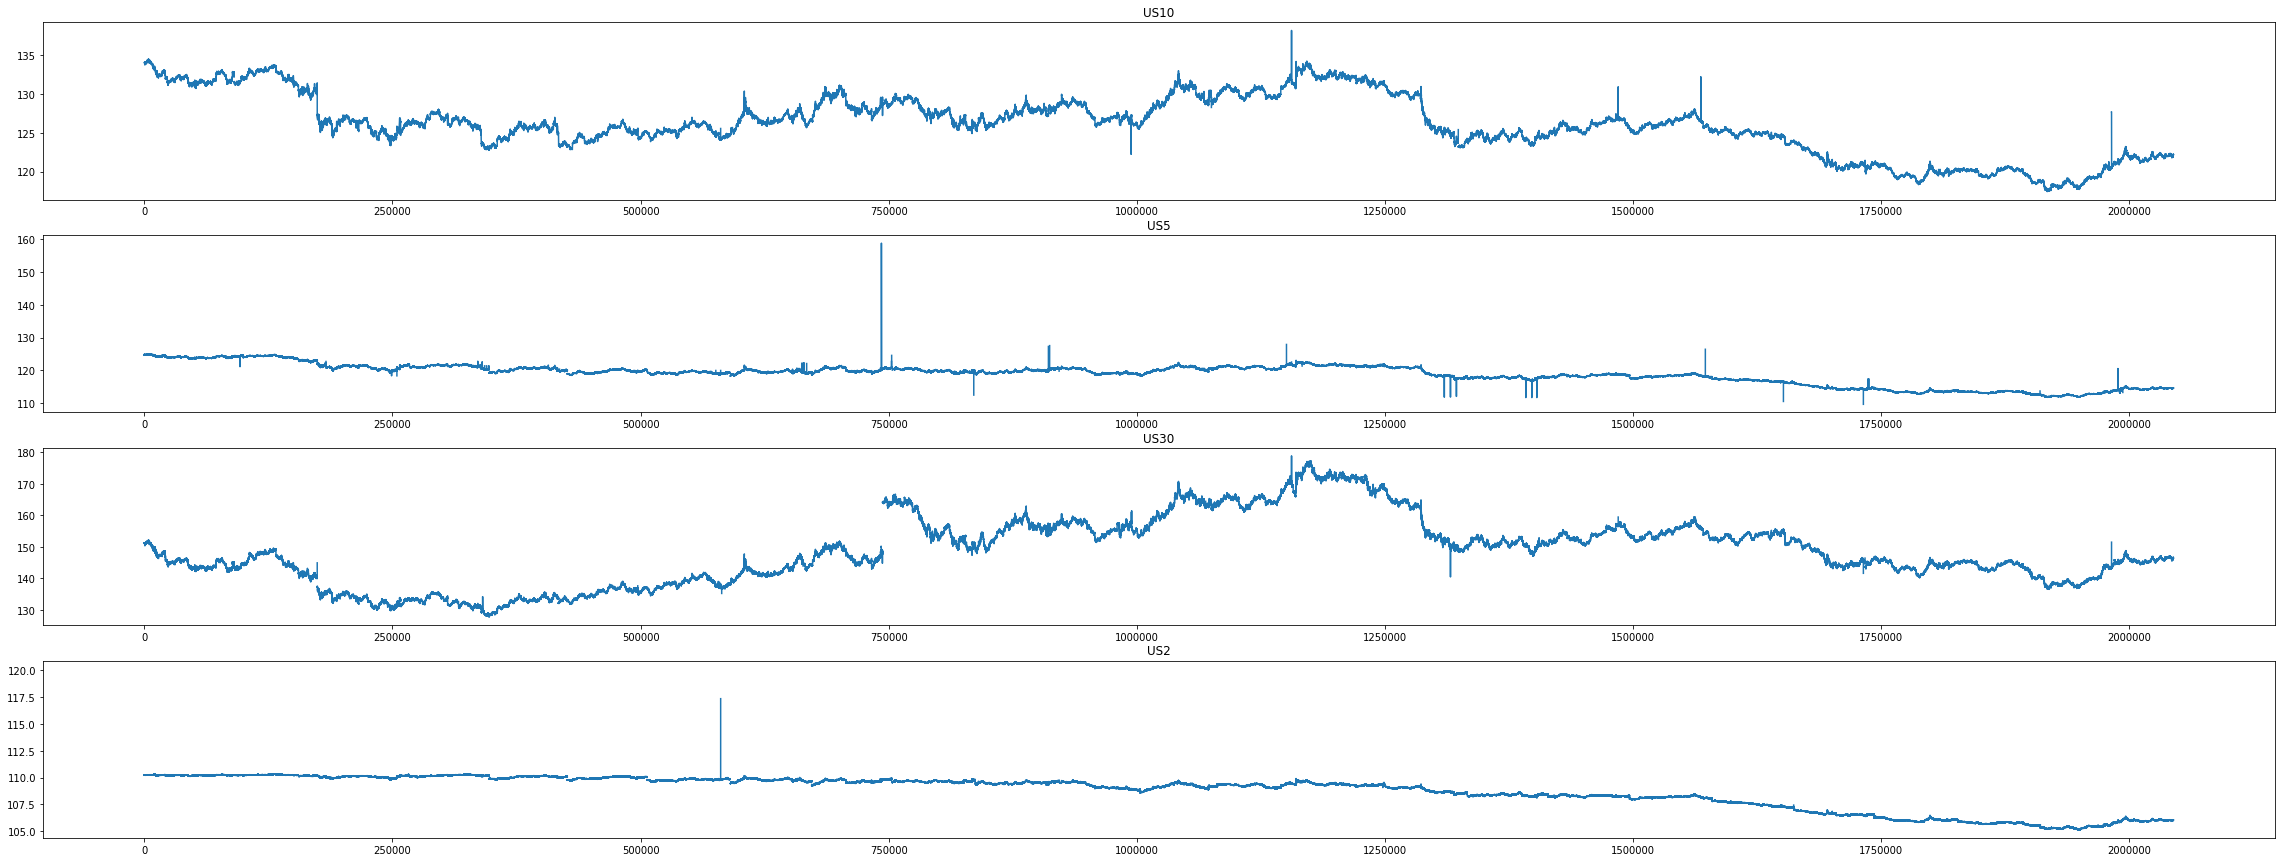

In [5]:
print(my_data.columns)
plt.figure(figsize=(40,15))
i=0
for x in ['US10','US5','US30','US2']:
    i+=1
    plt.subplot(4,1,i)
    plt.title(str(x))
    plt.plot(my_data['MID|'+str(x)])
plt.show()

In [6]:
# CREATEE BARS

#BID ASK FOR EACH 

my_data=my_data[['Date', 'BID|US10', 'ASK|US10', 'USLOCAL', 'BID|US30', 'ASK|US30',
       'BID|US5', 'ASK|US5','BID|US2','ASK|US2', 'USROLL']]
my_data["Date"]=pd.to_datetime(my_data["Date"])

my_data=my_data.set_index("Date")
index_list=[]
for x in ["US5","US10","US30"]:
    for y in ["BID","ASK"]:
         
        item=(my_data[str(y)+"|"+str(x)].resample('1H',label='right',closed='right').ohlc().index)
        index_list.append(item)
flat_list = list(set([item for sublist in index_list for item in sublist]))

new_frame=pd.DataFrame(index=flat_list)
new_frame=new_frame.sort_index()



new_frame["close"]=0
for x in ["US5","US10","US30","US2"]:
    for y in ["BID","ASK"]:
         
        dff=(my_data[str(y)+"|"+str(x)].resample('1H',label='right',closed='right').ohlc())
        dff=dff["close"]
        new_frame=new_frame.join(dff,rsuffix=str(y)+"|"+str(x))
        


my_data["TT"]=my_data.index
my_data["TT"]=my_data["TT"].astype(str).str.split(" ",expand=True)[0]
my_data=my_data.reset_index()
my_data=my_data.set_index(my_data["TT"])



new_frame["TT"]=new_frame.index
new_frame["TT"]=new_frame["TT"].astype(str).str.split(" ",expand=True)[0]
new_frame=new_frame.reset_index()
new_frame=new_frame.set_index(new_frame["TT"])

my_datas=my_data.copy()
my_datas=my_datas[["USROLL"]]
my_datas = my_datas[~my_datas.index.duplicated(keep='first')]
new_frame=new_frame.join(my_datas)

new_frame=new_frame.dropna()
new_frame=new_frame.set_index(new_frame["index"])
new_frame=new_frame.drop(["TT"],axis=1)
new_frame=new_frame.sort_index()
new_cols=[x.replace("close","") for x in new_frame.columns]
new_frame.columns=new_cols
for x in ['US10','US5','US30',"US2"]:
    new_frame['MID|'+str(x)]=0.5*(new_frame['ASK|'+str(x)]+new_frame['BID|'+str(x)])
new_frame=new_frame.dropna()

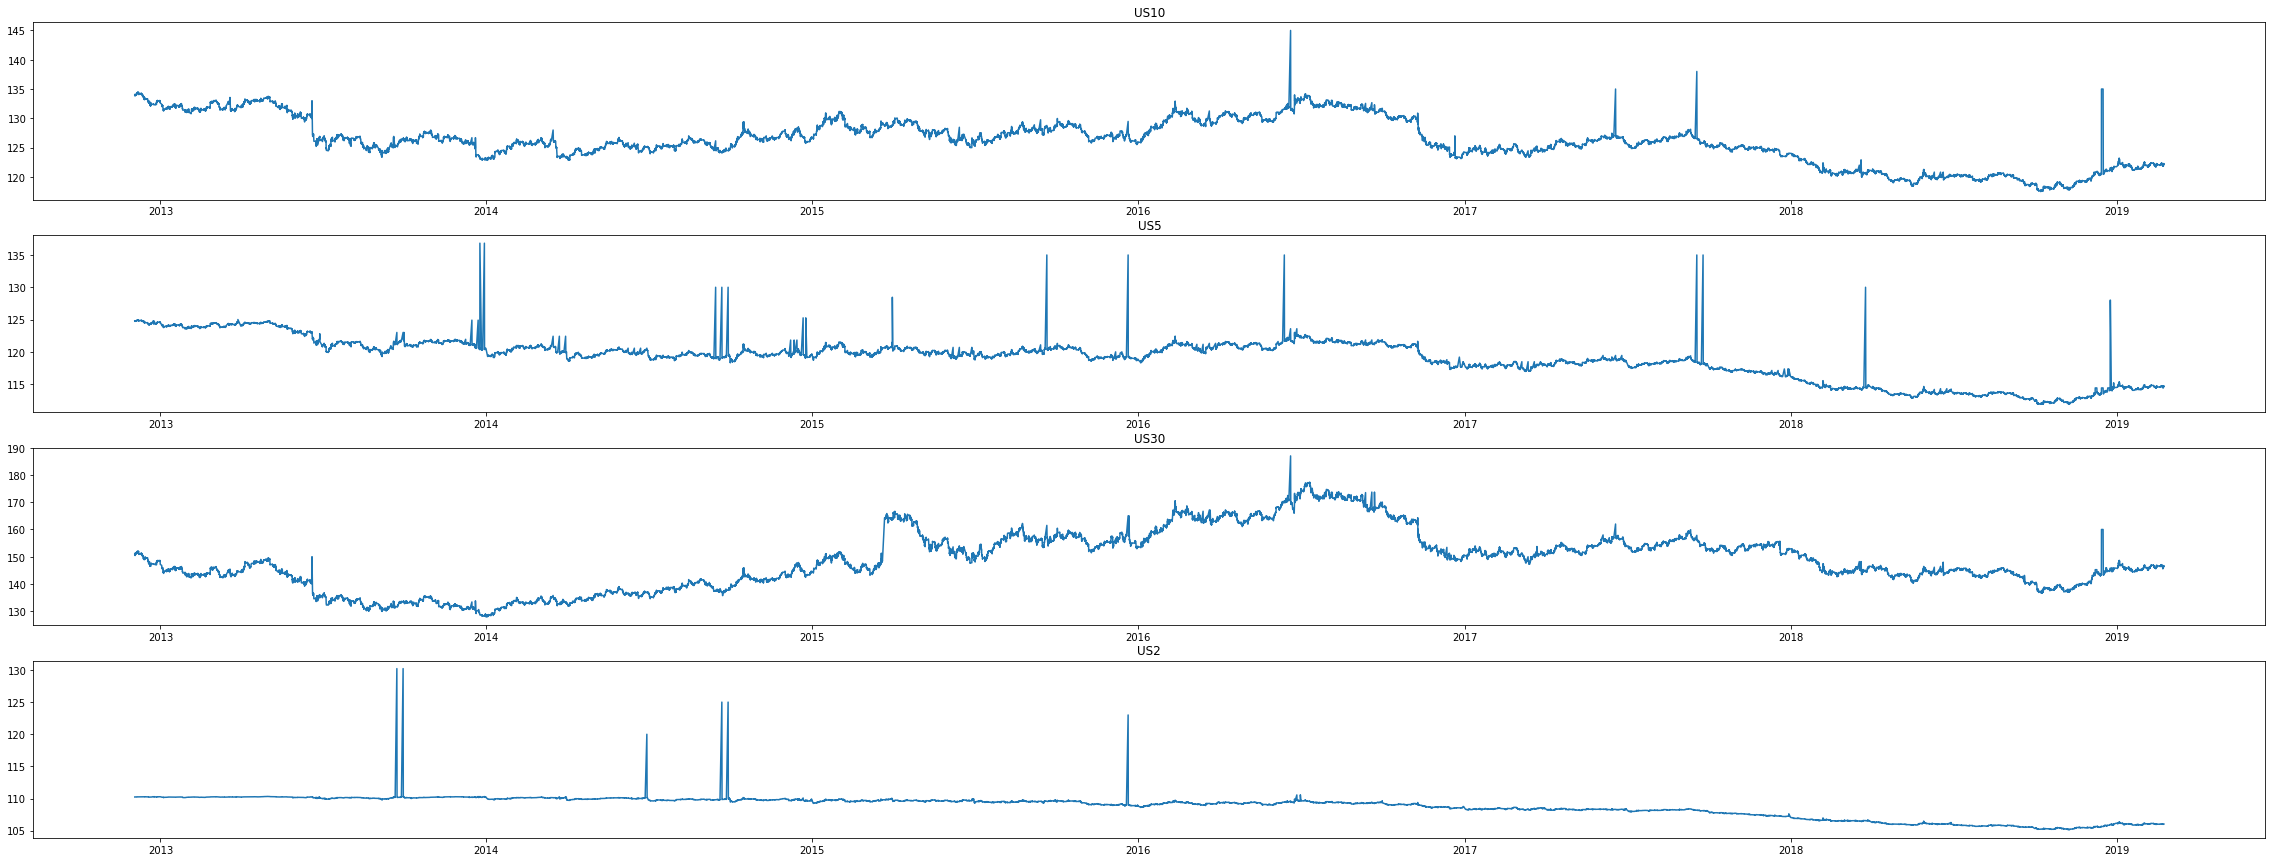

In [7]:
i=0
plt.figure(figsize=(40,15))
for x in ['US10','US5','US30','US2']:
    i+=1
    plt.subplot(4,1,i)
    plt.title(str(x))
    #plt.plot(new_frame['BID|'+str(x)])
    plt.plot(new_frame['ASK|'+str(x)])
plt.show()


Cleaning Data


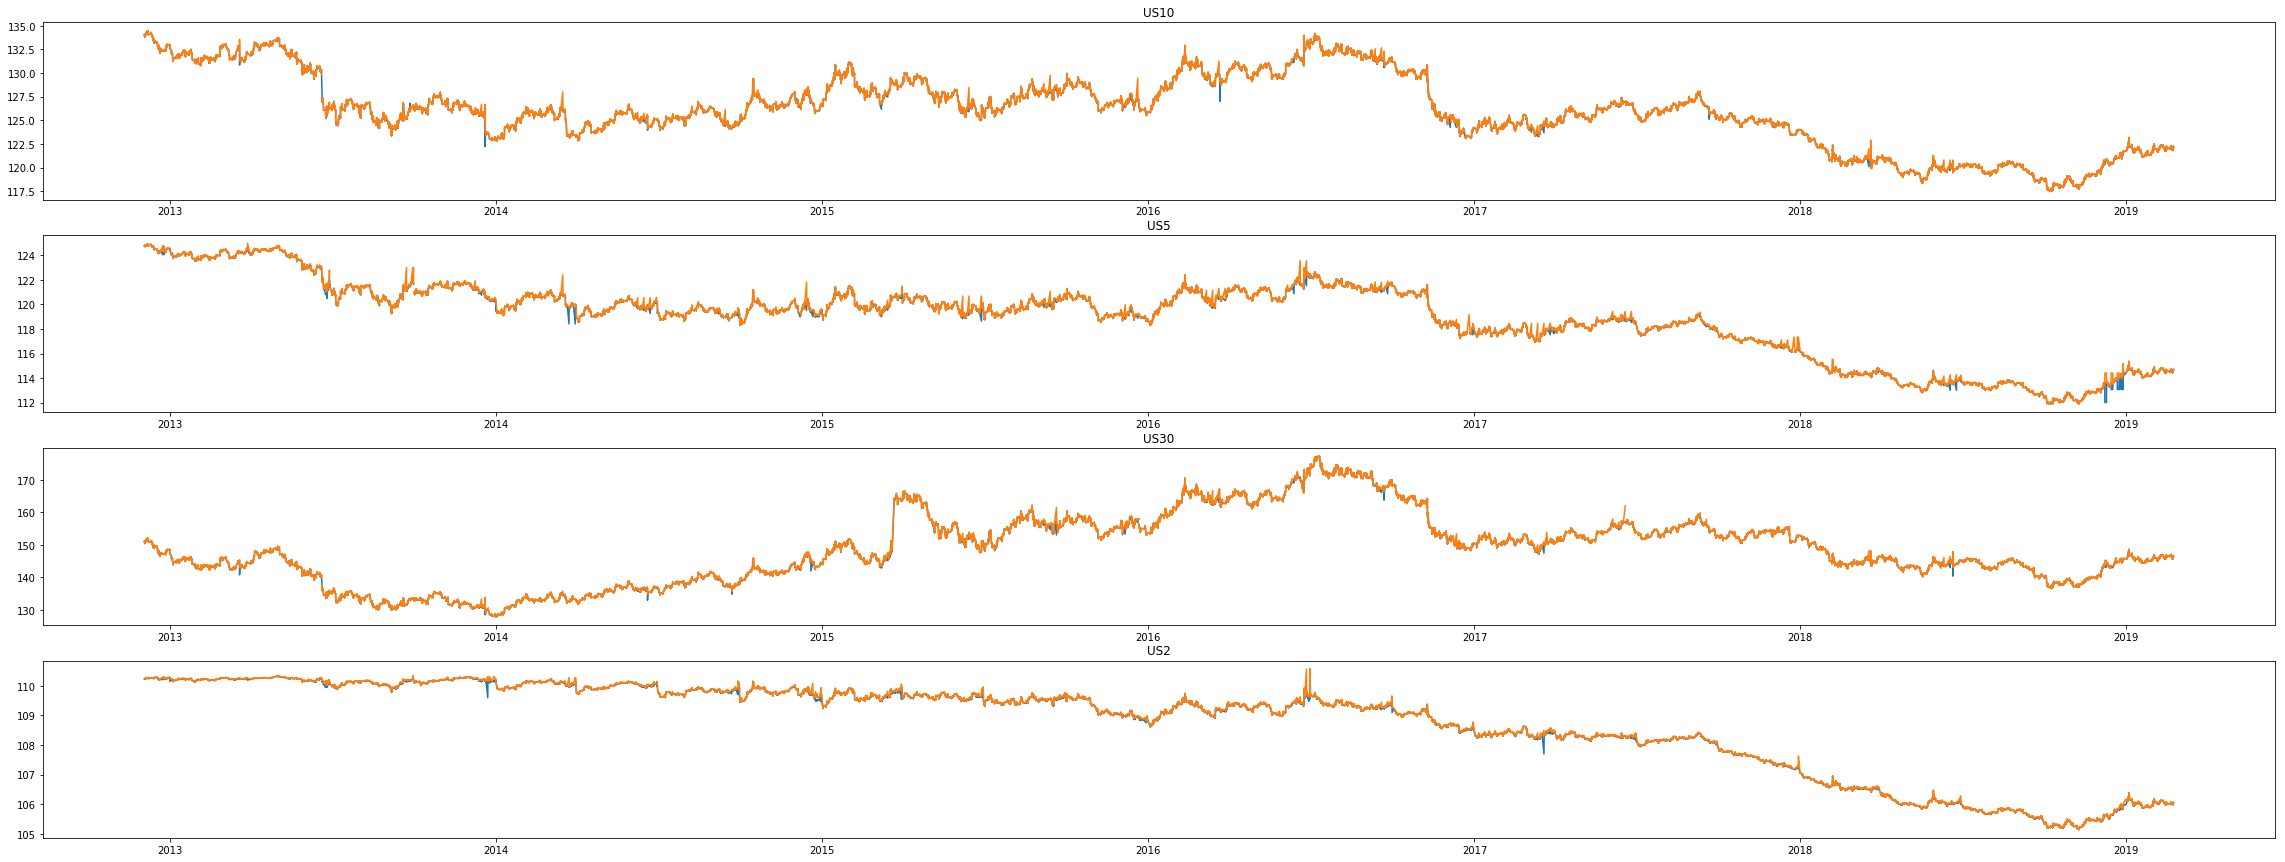

Index(['index', '', 'BID|US5', 'ASK|US5', 'BID|US10', 'ASK|US10', 'BID|US30',
       'ASK|US30', 'BID|US2', 'ASK|US2', 'USROLL', 'MID|US10', 'MID|US5',
       'MID|US30', 'MID|US2'],
      dtype='object')


In [8]:
#CLEAN THE DATA
print("Cleaning Data")
for s in ['BID|US5','ASK|US5','BID|US10','ASK|US10','BID|US30','ASK|US30','BID|US2','ASK|US2']:
    data=0
    data_list=[]
    date_criteria=[datetime(year=2015,month=3,day=15),datetime(year=2015,month=3,day=25)]
    range_criteria={'US2':1,'US5':2,'US10':3,'US30':5}
    label=s.split('|')[1]
    for x in range(len(new_frame)):
    
        val=new_frame[s].iloc[x]
        ind=new_frame[s].index[x]
        if x==0:
            data_list.append(val)
            data=val
        else:
            diff=data-val
            logic_diff=range_criteria[label]
            
            
            if np.abs(diff)<logic_diff:
                data=val
                data_list.append(data)
            elif np.abs(diff)>=logic_diff and label!='US30':
                data_list.append(np.nan)
            elif np.abs(diff)>=logic_diff and label=='US30' and ind>date_criteria[0] and ind<date_criteria[1]:
                data=val
                data_list.append(data) 
            elif np.abs(diff)>=logic_diff and label=='US30' and (ind<=date_criteria[0] or ind>=date_criteria[1]):
                data_list.append(np.nan) 
            else:
                print(label,ind,diff)
    new_frame[s]=data_list
        
       
        
    
plt.figure(figsize=(40,15))

'''
new_frame['BID|US5']=np.where(new_frame['BID|US5'].diff().abs()>1,np.nan,new_frame['BID|US5'])
new_frame['ASK|US5']=np.where(new_frame['ASK|US5'].diff().abs()>1,np.nan,new_frame['ASK|US5'])
new_frame['BID|US10']=np.where(new_frame['BID|US10'].diff().abs()>1,np.nan,new_frame['BID|US10'])
new_frame['ASK|US10']=np.where(new_frame['ASK|US10'].diff().abs()>1,np.nan,new_frame['ASK|US10'])
new_frame['BID|US30']=np.where(new_frame['BID|US30'].diff().abs()>1,np.nan,new_frame['BID|US30'])
new_frame['ASK|US30']=np.where(new_frame['ASK|US30'].diff().abs()>1,np.nan,new_frame['ASK|US30'])
new_frame['BID|US2']=np.where(new_frame['BID|US2'].diff().abs()>1,np.nan,new_frame['BID|US2'])
new_frame['ASK|US2']=np.where(new_frame['ASK|US2'].diff().abs()>1,np.nan,new_frame['ASK|US2'])



for i in ['BID|US5','ASK|US5','BID|US10','ASK|US10','BID|US30','ASK|US30','BID|US2','ASK|US2']:
    
    if i.split('|')[1]=='US2':
 
        new_frame[i]=np.where(new_frame[i].diff().abs()>0.5,np.nan,new_frame[i])
        #new_frame[i] = new_frame[i].fillna(method='ffill')
    elif i.split('|')[1]=='US5':
        new_frame[i]=np.where(new_frame[i].diff().abs()>2,np.nan,new_frame[i])
        #new_frame[i] = new_frame[i].fillna(method='ffill')
    elif i.split('|')[1]=='US10':
        new_frame[i]=np.where(new_frame[i].diff().abs()>3,np.nan,new_frame[i])       
        #new_frame[i] = new_frame[i].fillna(method='ffill')
    elif i.split('|')[1]=='US30':
        
        new_frame[i]=np.where(np.logical_and(new_frame[i].diff().abs()>5 , (new_frame[i].index<datetime(year=2015,month=3,day=15)) , (new_frame[i].index>datetime(year=2015,month=3,day=25)))  ,np.nan,new_frame[i])  

        #new_frame[i] = new_frame[i].fillna(method='ffill')

i=0

#new_frame=new_frame.fillna(method='ffill')



'''
#new_frame=new_frame.drop([x for x in new_frame.columns if '_' in x],axis=1)
i=0
for x in ['US10','US5','US30','US2']:
    new_frame['MID|'+str(x)]=0.5*(new_frame['ASK|'+str(x)]+new_frame['BID|'+str(x)])
    i+=1
    plt.subplot(4,1,i)
    plt.title(str(x))
    plt.plot(new_frame['BID|'+str(x)])
    plt.plot(new_frame['ASK|'+str(x)])
    
    
plt.show()
print(new_frame.columns)


In [9]:
plt.figure(figsize=(40,15))
new_frame=new_frame.fillna(method='ffill')

i=0
for x in ['US10','US5','US30','US2']:
    new_frame['MID|'+str(x)]=0.5*(new_frame['ASK|'+str(x)]+new_frame['BID|'+str(x)])
    i+=1
    plt.subplot(4,1,i)
    plt.title(str(x))
    plt.plot(new_frame['BID|'+str(x)])
    plt.plot(new_frame['ASK|'+str(x)])
    

In [10]:
#SPREAD CHECK
min_spread={'US2':(1/32)/4,'US5':(1/32)/4,'US10':(1/32)/2,'US30':(1/32)}



for x in ['US5','US10','US30']:
    new_frame=new_frame[new_frame['ASK|'+str(x)]-new_frame['BID|'+str(x)]>0]
    min_spp=min_spread[x]
    check_num=min_spread[x]
    new_frame['ASK|'+str(x)]=(np.where(new_frame['ASK|'+str(x)]-new_frame['BID|'+str(x)]<check_num,new_frame['BID|'+str(x)]+min_spp,new_frame['ASK|'+str(x)]))
a_list=[]
for x in range(len(new_frame)):

    cur_index=new_frame.index[x]
    if new_frame.index[x]<datetime(year=2019,month=1,day=13):
        if (new_frame['ASK|US2'].iloc[x]-new_frame['BID|US2'].iloc[x])<(1/32)/4:

            a_list.append(new_frame['BID|US2'].iloc[x]+(1/32)/4)
        else:
            a_list.append(new_frame['ASK|US2'].iloc[x])

            
    else:
        if (new_frame['ASK|US2'].iloc[x]-new_frame['BID|US2'].iloc[x])<(1/32)/8:
            
            a_list.append(new_frame['BID|US2'].iloc[x]+(1/32)/8)
        else:
            a_list.append(new_frame['ASK|US2'].iloc[x])
print('SPREAD CHECK')
new_frame['ASK|US2']=a_list
for x in ['US10','US5','US30','US2']:

    print('---'+str(x)+'---')
    print(sorted((new_frame['ASK|'+str(x)]-new_frame['BID|'+str(x)]).unique())[:10])
    
    


SPREAD CHECK
---US10---
[0.015625, 0.03125, 0.046875, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625]
---US5---
[0.0078125, 0.015625, 0.0234375, 0.03125, 0.0390625, 0.046875, 0.0546875, 0.0625, 0.0703125, 0.078125]
---US30---
[0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.28125, 0.3125]
---US2---
[0.00390625, 0.0078125, 0.015625, 0.0234375, 0.03125, 0.0390625, 0.046875, 0.0546875, 0.0625, 0.0703125]


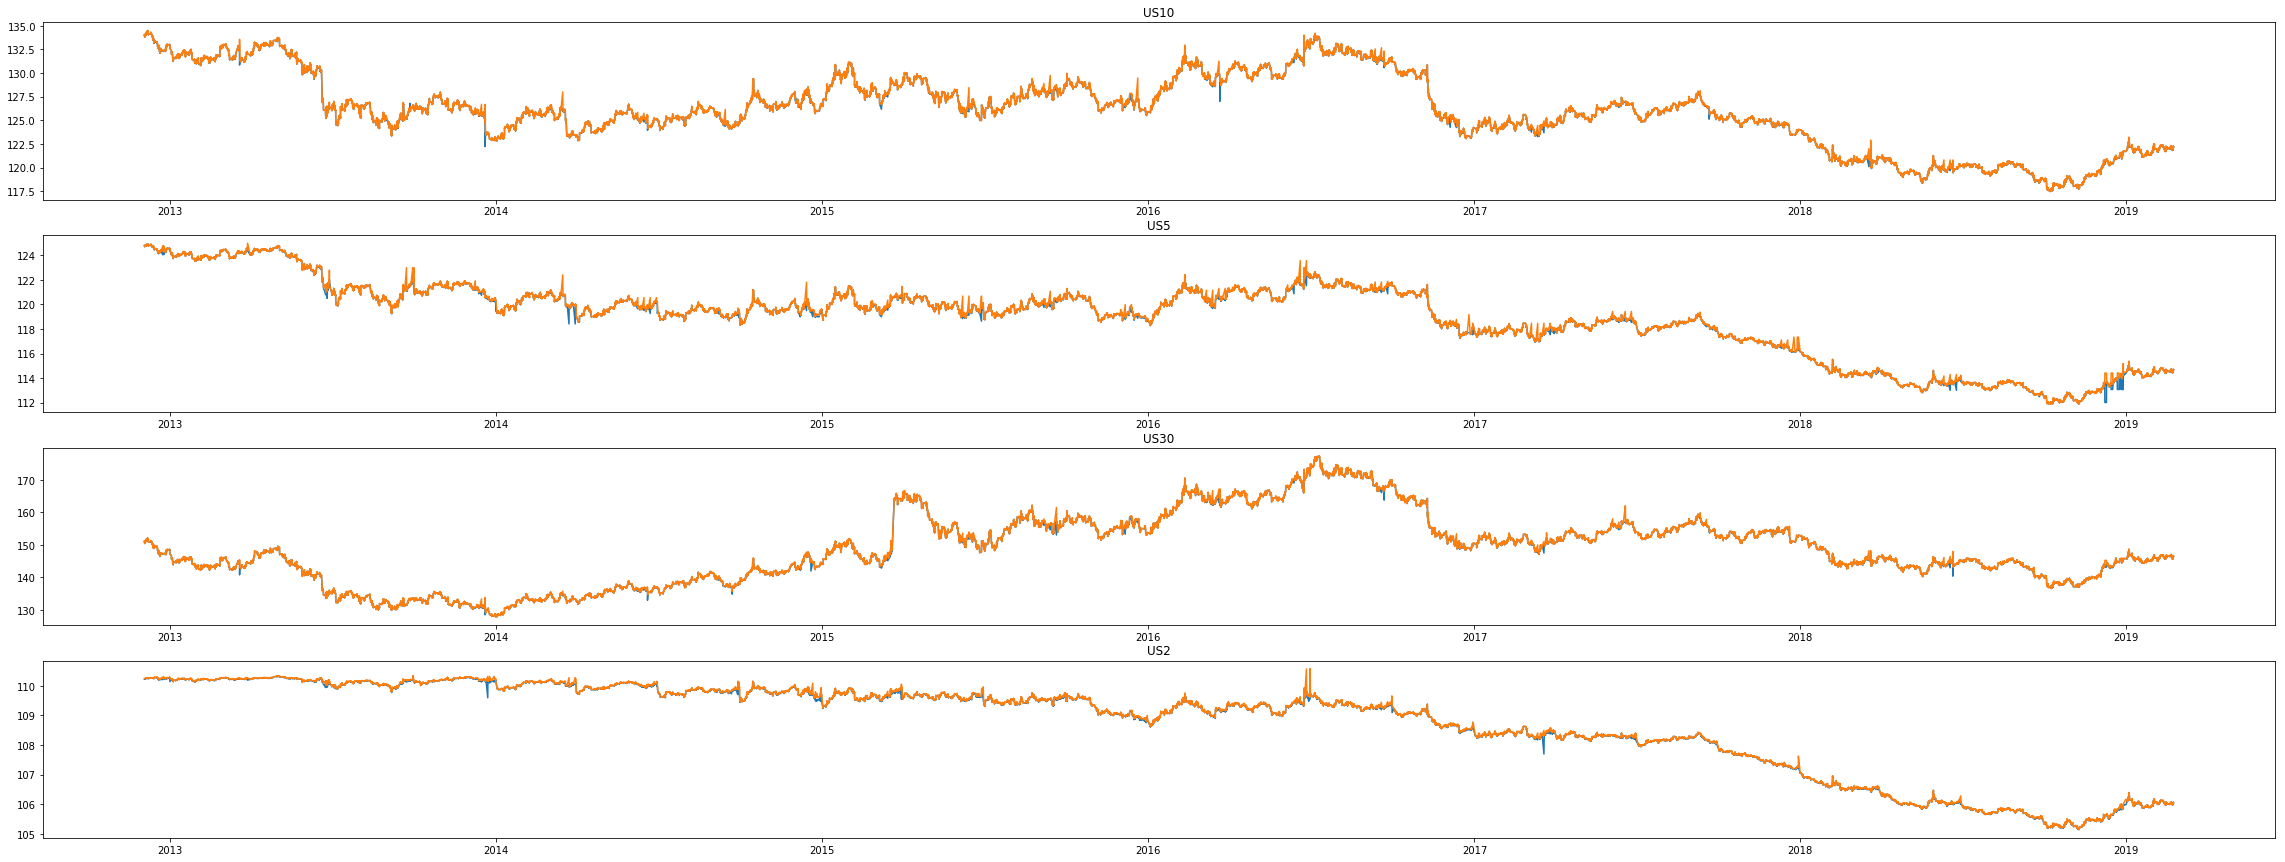

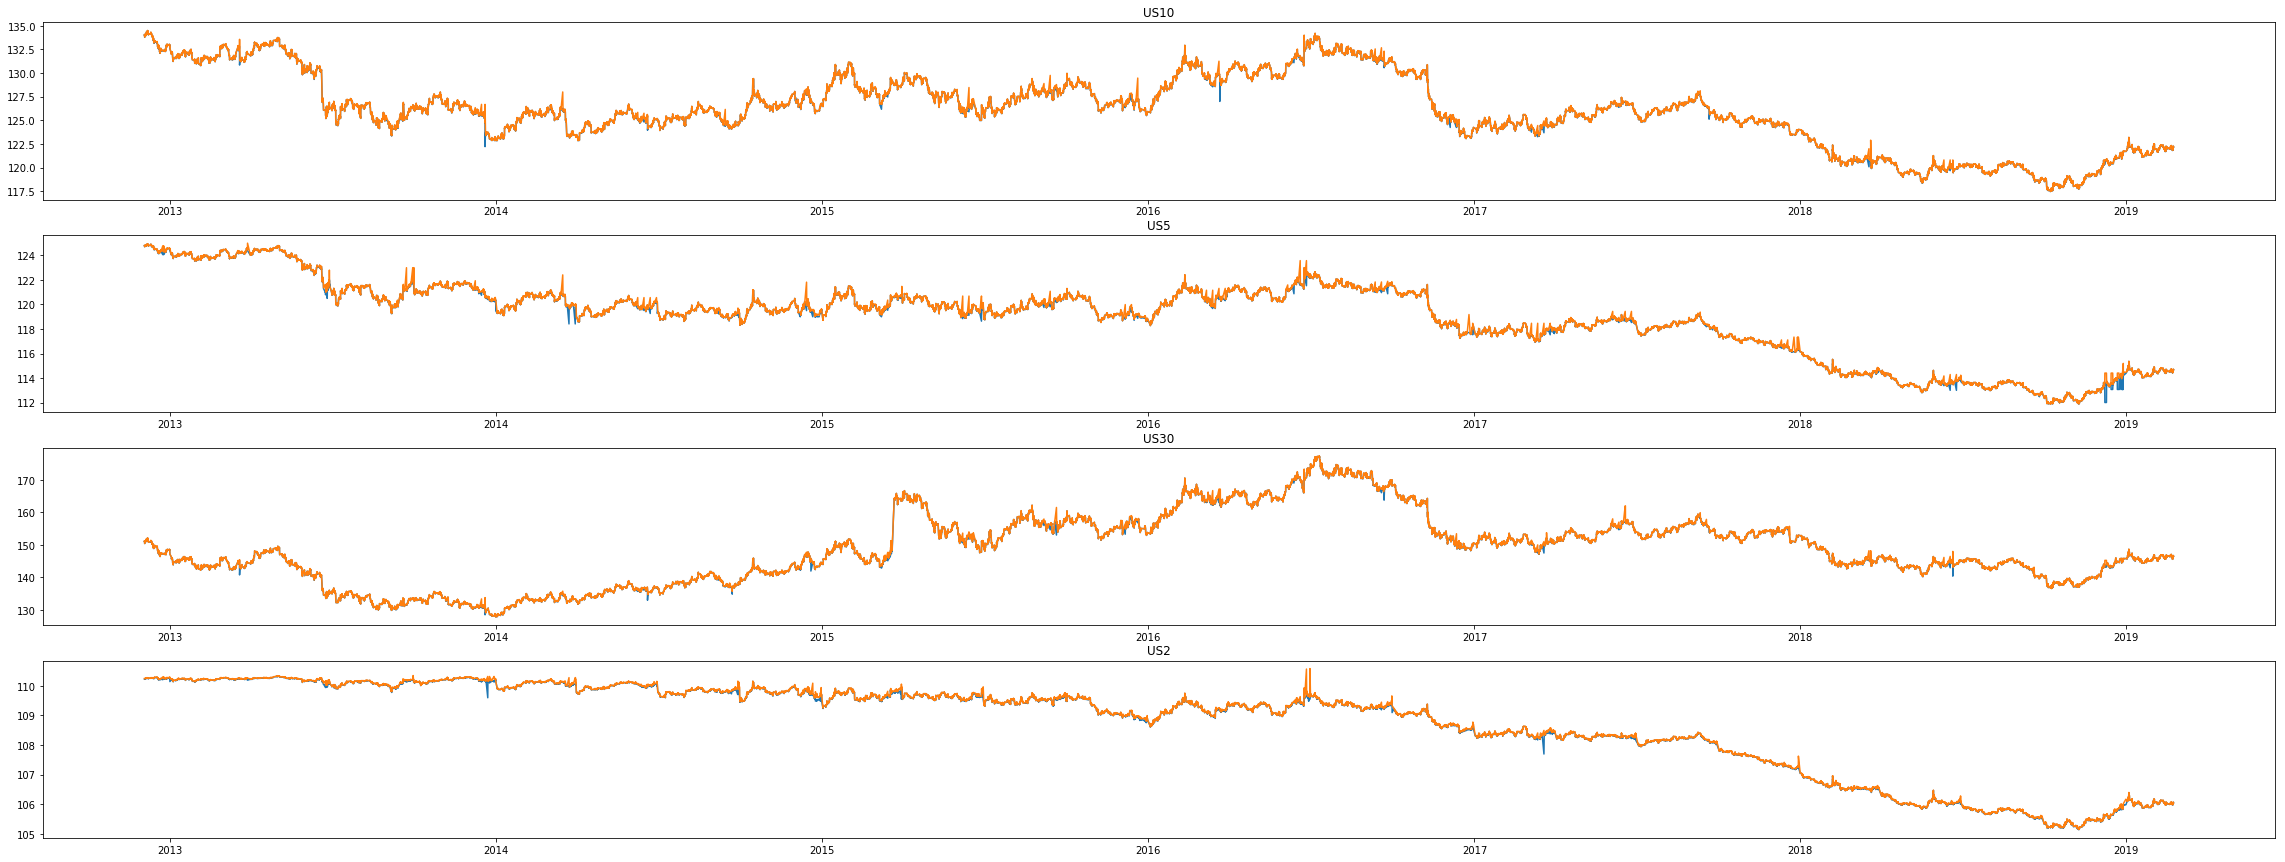

In [11]:
i=0
plt.figure(figsize=(40,15))
new_frame=new_frame.dropna()
for x in ['US10','US5','US30','US2']:
    new_frame['MID|'+str(x)]=0.5*(new_frame['ASK|'+str(x)]+new_frame['BID|'+str(x)])
    i+=1
    plt.subplot(4,1,i)
    plt.title(str(x))
    plt.plot(new_frame['BID|'+str(x)])
    plt.plot(new_frame['ASK|'+str(x)])
    
    
plt.show()

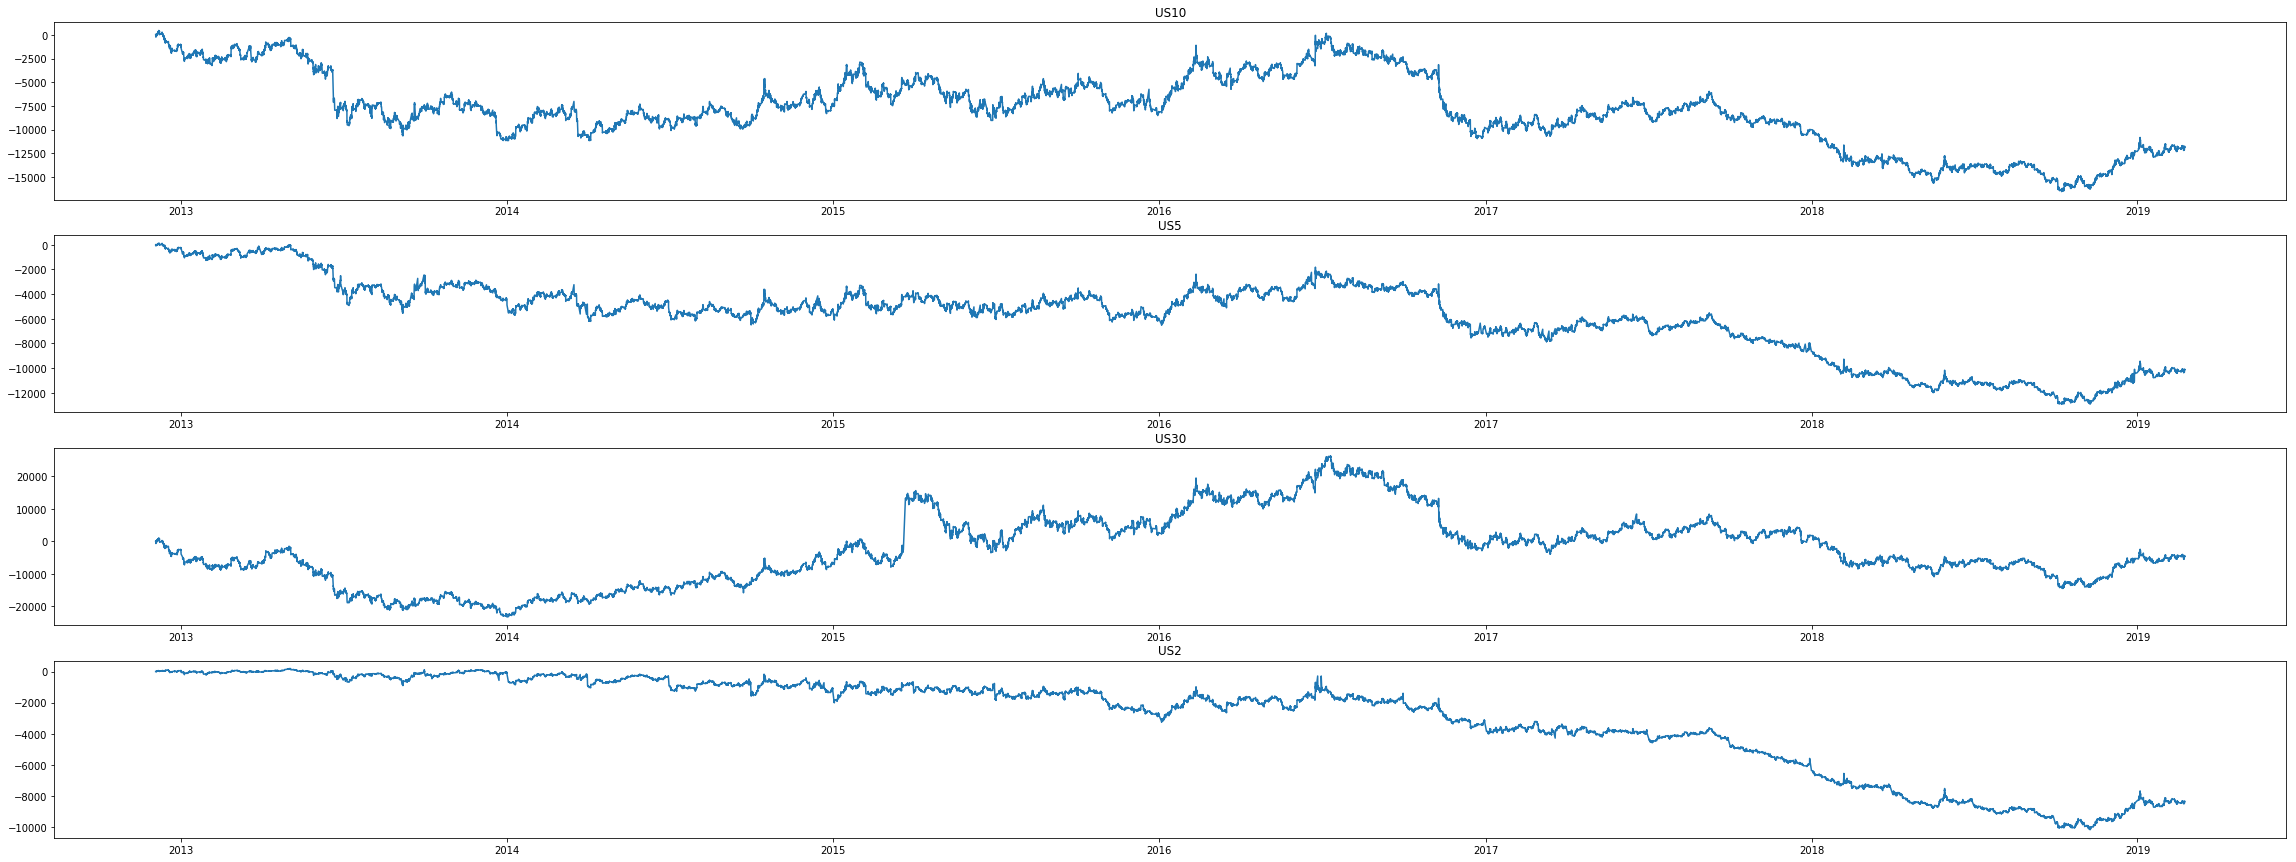

In [12]:
#ADD TIME TO ROLL
roll_days=new_frame[new_frame['USROLL']==1]
dates=list(set([x[0] for x in list(roll_days.index.map(str).str.split(' '))]))
time_to_expiry=[]
dates.append('2019-03-31')
for x in range(len(new_frame)):
    ind=(new_frame.index[x])
    diffs=[]
    for y in dates:
        my_date=datetime.strptime(y,"%Y-%m-%d")
        timedelta=my_date-ind
        
        if timedelta.days>=0:
            diffs.append(timedelta)

    time_to_expiry.append(np.min(diffs).days)
new_frame['TIMETOROLL']=time_to_expiry



# CREATE TH

#FOR 5
#One-quarter of one thirty-second (1/32) of one point ($7.8125, rounded to the nearest cent per contract), including intermonth spreads.




US_TICK=31.25


new_frame["TH|US5"]=new_frame["TH|US10"]=new_frame["TH|US30"]=new_frame["TH|US2"]=0
new_frame["TH|US5"]=new_frame["MID|US5"].diff()/(1/32)*US_TICK
new_frame["TH|US10"]=new_frame["MID|US10"].diff()/(1/32)*US_TICK
new_frame["TH|US30"]=new_frame["MID|US30"].diff()/(1/32)*US_TICK
new_frame["TH|US2"]=new_frame["MID|US2"].diff()/(1/32)*US_TICK*2
new_frame=new_frame.dropna()

constant=0
new_frame["TH|US5"]=new_frame["TH|US5"].cumsum()+constant
new_frame["TH|US10"]=new_frame["TH|US10"].cumsum()+constant
new_frame["TH|US30"]=new_frame["TH|US30"].cumsum()+constant
new_frame["TH|US2"]=new_frame["TH|US2"].cumsum()+constant
plt.figure(figsize=(40,15))
i=0

#FOR 2 YEARS FACE VALUE IS 

#One-eighth of one thirty-second (1/32) of one point ($7.8125, rounded to the nearest cent per contract), including intermonth spreads.
# US2 has a tick range(0.01) for 2000 meanwhile others are 1000$.
#US2 change goes from 1/4 to 1/8 after Jan 2019.


for x in ['US10','US5','US30','US2']:
    i+=1
    plt.subplot(4,1,i)
    plt.title(str(x))
    plt.plot(new_frame['TH|'+str(x)])
plt.show()




In [27]:
def get_feature_prices(input_array,features_bid,features_ask,ii):
    z=[]
    ss=0
    for x in input_array:
        if x==1:#features_b[:,i]
            z.append(features_bid[ss,ii])
        if x==-1:#features_b[:,i]
            z.append(features_ask[ss,ii])
        ss+=1
    return np.array(z)

def calc_profit(main_pos,input_array,entry_main_actual,exit_main_actual,entry_leg_actual,exit_leg_actual,coefficients):
    
   # print("-"*20,"PROFIT_CALC")
   # print("Coef:",coefficients)
    tot_prof=0
    zz=[]
    profits=[]
    if main_pos==1:
        #BUY THE MAIN, SELL THE LEGS
        main_profit=(exit_main_actual-entry_main_actual)/(1/32)*31.25
    elif main_pos==-1:
        main_profit=(-exit_main_actual+entry_main_actual)/(1/32)*31.25


    profits.append(main_profit)
    s=0
    for x in input_array:
        if x==1:
            leg_profit=(exit_leg_actual[s]-entry_leg_actual[s])/(1/32)*31.25*np.abs(coefficients[s])
        elif x==-1:
            leg_profit=(-exit_leg_actual[s]+entry_leg_actual[s])/(1/32)*31.25*np.abs(coefficients[s])
        s+=1
        profits.append(leg_profit)


    #print("coef ",coefficients)
    #print("positions main",main_pos,"positions leg",input_array)
    #print("Prices open_main:",entry_main_actual,"open leg1:",entry_leg_actual[0],"open leg2:",entry_leg_actual[1])
    #print("Prices close_main:",exit_main_actual,"close leg1:",exit_leg_actual[0],"close leg2:",exit_leg_actual[1])
    #print("Profit MAIN:",profits[0],"profit leg1:",profits[1],"profit leg2:",profits[2])
    #print("Total Profit:",np.sum(profits))
    #print("Comissions:",((np.sum(np.abs(coefficients)))+1)*2)
    return np.sum(profits)-1.6*((np.sum(np.abs(coefficients)))+1)*2





def backtest(bnd,TIME_EXIT,lkbk,MAX_LOOP,COMMS_MULTIPLIER,feature_list,classifier_list,cost_dict,ROLL_ENABLER,ENABLE_SPREAD,TRADING_HALT_BEFORE_ROLL):
    model = LinearRegression()
    #ROLL_ENABLER=1 # 1 if the we don't want to trade at rolls
    ROLL_AVOID=TRADING_HALT_BEFORE_ROLL # dont enter trades if time to roll is this or less days
    ENABLE_SPREAD=ENABLE_SPREAD#disable checking spread
    
    labels=" B:"+str(bnd)+"|E: "+str(TIME_EXIT)+"|L: "+str(lkbk)+"|ML:"+str(MAX_LOOP)+"|C:"+str(COMMS_MULTIPLIER)
    

    features = np.asarray([new_frame['TH|'+str(x)] for i,x in enumerate(feature_list)])
    features_b = np.asarray([new_frame['MID|'+str(x)] for i,x in enumerate(feature_list)])
    classifier = np.asarray(new_frame['TH|'+classifier_list[0]])
    classifier_b = np.asarray(new_frame['MID|'+classifier_list[0]])

    datesss=np.asarray(new_frame.index)
    
    features_bid = np.asarray([new_frame['BID|'+str(x)] for i,x in enumerate(feature_list)])
    features_ask = np.asarray([new_frame['ASK|'+str(x)] for i,x in enumerate(feature_list)])
    
    classifier_bid = np.asarray(new_frame['BID|'+classifier_list[0]])
    classifier_ask = np.asarray(new_frame['ASK|'+classifier_list[0]])
    

    time_to_roll = np.asarray(new_frame['TIMETOROLL'])
    
    roll_data=np.asarray(new_frame['USROLL'])
    inpos = 0
    cnt = 10000
    
    pnls = []
    dates = []
    residual=0
    curr_price=0
    op=0
    com_list=[]
    entry=0
    ttt=0
    stds=[]
    ppp=[]
    spread_list=[]
    #costs=[31*0.9+(1.6*2),16+(1.6*2),50*0.9+3.2,32+(1.6*2)]
    costs=[]
    for x in feature_list:
        if x in [x for x in cost_dict.keys()]:
            costs.append(cost_dict[x])
 

    for i in range(lkbk+1,classifier.shape[0]-4):
        if datesss[i]>np.datetime64('2014-01-01'):
            cnt += 1
            if  inpos==0 and cnt>MAX_LOOP:

                ft = features[:,i-lkbk:i]
                cl = classifier[i-lkbk:i]

                #cl=((np.diff(cl).cumsum()))
                #ft = (np.diff(ft)).cumsum(axis=1)

                


                #testtt=[ft,cl]
                #return testtt
                model.fit(ft.T,cl)
                residual = np.sum(model.coef_*features[:,i-lkbk:i].T,axis=1)-classifier[i-lkbk:i]+model.intercept_ 
                bw = np.std(residual)
                comissions=(np.sum(np.array(costs)*np.abs(model.coef_))+cost_dict[classifier_list[0]])
                comissions_real=comissions
                '''
                print("###########################")
                print("RECALC CALLED")
                print(datesss[i])

                print("###########################")
                
                print(datesss[i])
                print("LAST CALL")
                for x in ft[0,:]:
                    print(x)
                print("CLASS")

                for x in cl:
                    print(x)
                '''
                pos = 1#(np.abs(curr_price)/bw)
                cnt = 0

            if i>lkbk+3:
                curr_price = np.sum(model.coef_*features[:,i])-classifier[i]+model.intercept_

                residual = np.sum(model.coef_*features[:,i-lkbk:i].T,axis=1)-classifier[i-lkbk:i]+model.intercept_ 
                stds.append(curr_price)

                spr_check=0
                logical_spreads_dict={"US2":1.1*((1/32)/4),"US5":1.1*((1/32)/4),"US10":1.1*((1/32)/2),"US30":1.1*((1/32))}

                all_instruments=classifier_list+feature_list
                spr_check=0
                z=0
                for ins in all_instruments:
                    logic=logical_spreads_dict[ins]
                    if z==0:
                        actual_spread=classifier_ask[i]-classifier_bid[i]
                    else:
                        actual_spread=features_ask[z-1,i]-features_bid[z-1,i]
                    z+=1

                    if actual_spread<logic*2:
                        spr_check+=1    






                #print(bw,curr_price)
                #print(datesss[i],curr_price,bw*bnd)

         #   if inpos==-1:
                
            '''
            print("---")
            print("DateTime:",datesss[i])
            print("EntryResid:",entry)
            print("Thold:",entry-comissions*COMMS_MULTIPLIER)
            print("Last Reid:",curr_price)
            print("Class Price",(classifier_bid[i]+classifier_ask[i])/2)
            print("Feat Price",(features_bid[0,i]+features_ask[0,i])/2)
            print("Coef",model.coef_)
            print("Int",model.intercept_)
            print('REVTHOLD:',-bw*bnd)
            print('REVCOM:',-comissions )
            print('BW:',bw )
            print('SDEVR:',bnd )
            print("ROLLDATA", roll_data[i])
            print("Increment Since Update:",cnt)
            print("---")
            
            if (datesss[i]==np.datetime64('2014-01-03')):

                print("FEAT THEO")
                for x in features[0,i-lkbk:i]:
                    print(x);

                print("CLASS THEO")
                for x in  classifier[i-lkbk:i]:
                    print(x)

                print("FEAT MID")
                for x in features_b[0,i-lkbk:i]:
                    print(x)

                print("CLASS MID")
                for x in classifier_b[i-lkbk:i]:
                    print(x)



            '''
            if (curr_price > bw*bnd 
                and inpos == 0 
                and curr_price>comissions 
                and spr_check>=len(all_instruments)*ENABLE_SPREAD 
                and time_to_roll[i]>ROLL_AVOID*ROLL_ENABLER 
                and roll_data[i]<1+(1-ROLL_ENABLER)
                and datesss[i]>np.datetime64('2014-01-01')):

                print(type(datesss[i]))
                inpos = -1
                #print('short enter ',datesss[i])
                #print("Entry Price:",features_b[:,i],features[:,i],model.coef_)
                entry = curr_price
                op = i 
                entry_b1 =  features_b[:,i]
                entry_b2 = classifier_b[i]

                #BUY THE CLASSIFIER FROM ASK
                entry_b2_act=classifier_ask[i]


                input_array=(np.sign(model.coef_))
                entry_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)



                #BUY THE WEIGHTS
                entry_spread1=features_ask[:,i]-features_bid[:,i]
                entry_spread2=classifier_ask[i]-classifier_bid[i]
                
                print("-----------------------------------------------")
                print("SHORT ENTRY")
                print("Datetime:",datesss[i])
                print("5 ENTER PRICE",entry_b2_act)
                print("10 ENTER PRICE",entry_b1_act)
                print("WEIGHTS",model.coef_)
                print("INTERCEPT",model.intercept_)
                print("RESIDUAL",curr_price)
                print("COSTING:",comissions)
                
                
                


                #spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])



            elif ((i-op>TIME_EXIT 
                and inpos==-1 
                and spr_check>=len(all_instruments)*ENABLE_SPREAD 
                and roll_data[i]<1+(1-ROLL_ENABLER)) 
                or 
                (inpos == -1 
                and (curr_price < entry-comissions*COMMS_MULTIPLIER) 
                and spr_check==len(all_instruments) 
                and roll_data[i]<=1+(1-ROLL_ENABLER) )):

                pnl = (-curr_price + entry)*pos
                pnl_b = (sum(entry_b1 * model.coef_) - entry_b2) - (sum(features_b[:,i]*model.coef_) - classifier_b[i])

                #short features, long the class


                exit_b2_act=classifier_bid[i]
                input_array=(np.sign(model.coef_)*-1)
                exit_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)

                pp=calc_profit(inpos*-1,input_array,entry_b2_act,exit_b2_act,entry_b1_act,exit_b1_act,model.coef_)
                inpos = 0


                entry_spread1=features_ask[:,i]-features_bid[:,i]
                entry_spread2=classifier_ask[i]-classifier_bid[i]
                #spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])

                ppp.append(pp)
                pnls.append(pnl-comissions_real*pos)
                dates.append(i)
                
                print("SHORT EXIT")
                print("Datetime:",datesss[i])
                print("5 EXIT PRICE",exit_b2_act)
                print("10 EXIT PRICE",exit_b1_act)
                print("WEIGHTS",model.coef_)
                print("RESIDUAL",curr_price)
                print("PROFIT:",pp)
                

                #print("Exit Price:",features_b[:,i],features[:,i],model.coef_,pnl-comissions_real*pos,)

            elif (curr_price < -bw*bnd 
                and inpos == 0  
                and curr_price<-comissions 
                and spr_check>=len(all_instruments)*ENABLE_SPREAD
                and time_to_roll[i]>ROLL_AVOID*ROLL_ENABLER 
                and roll_data[i]<1+(1-ROLL_ENABLER)
                and datesss[i]>np.datetime64('2014-01-01')):
                inpos = 1
                #print('long enter ',datesss[i])
                entry = curr_price
                op = i
                entry_b1 =  features_b[:,i]
                entry_b2 = classifier_b[i]

                #entry_b2_act=classifier_ask[i]
                #BSELL THE CLASSIFIER FROM BID
                entry_b2_act=classifier_bid[i]
                input_array=(np.sign(model.coef_)*-1)
                entry_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)

                entry_spread1=features_ask[:,i]-features_bid[:,i]
                entry_spread2=classifier_ask[i]-classifier_bid[i]
                #spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])
                
                print("-----------------------------------------------")
                print("LONG ENTRY")
                print("Datetime:",datesss[i])
                print("5 ENTER PRICE",entry_b2_act)
                print("10 ENTER PRICE",entry_b1_act)
                print("WEIGHTS",model.coef_)
                print("INTERCEPT",model.intercept_)
                print("RESIDUAL",curr_price)
                print("COSTING:",comissions)
                

            elif ((i-op>TIME_EXIT 
                and inpos==1 
                and spr_check>=len(all_instruments)*ENABLE_SPREAD 
                and roll_data[i]<1+(1-ROLL_ENABLER)) 
                or (inpos == 1 
                and (curr_price > entry+comissions*COMMS_MULTIPLIER) 
                and spr_check==len(all_instruments) 
                and roll_data[i]<1+(1-ROLL_ENABLER))) :
                
       
                    

                pnl = (curr_price - entry)*pos
                pnl_b = -(sum(entry_b1 * model.coef_) - entry_b2) + (sum(features_b[:,i]*model.coef_) - classifier_b[i])
               # print(pnl-comissions_real*pos)

                pnls.append(pnl-comissions_real*pos) 
                dates.append(i)
                #exit_b2_act=classifier_bid[i]
                #BUY THE CLASSIFIER FROM ASK
                exit_b2_act=classifier_ask[i]
                input_array=(np.sign(model.coef_))
                exit_b1_act=get_feature_prices(input_array,features_bid,features_ask,i)

                pp=calc_profit(inpos*-1,input_array,entry_b2_act,exit_b2_act,entry_b1_act,exit_b1_act,model.coef_)

                print("LONG EXIT")
                print("Datetime:",datesss[i])
                print("5 EXIT PRICE",exit_b2_act)
                print("10 EXIT PRICE",exit_b1_act)
                print("WEIGHTS",model.coef_)
                print("RESIDUAL",curr_price)      
                print("PROFIT:",pp)

                #@break
                ppp.append(pp)
                inpos = 0

                entry_spread1=features_ask[:,i]-features_bid[:,i]
                entry_spread2=classifier_ask[i]-classifier_bid[i]

                #spread_list.append([entry_spread1[0],entry_spread1[1],entry_spread2])

    
    
    return dates,ppp,spread_list,pnls,labels



In [ ]:
def stdev_csharp(data):
    
    dps=0
    mean=np.mean(data)
    for x in data:
        dp=(x-mean)*(x-mean)
        dps+=dp
    ret=np.sqrt(dps/((len(data))))
    return ret    

In [71]:
residual=np.random.randn(100)

In [72]:
stdev_csharp(residual)

0.9718831696860868

In [73]:

np.std(residual)

0.9718831696860871

In [74]:
total_iter=len(BANDWIDTHS)*len(COMBINS)*len(LOOKBACKS)*len(TIME_EXITS)*len(COMISSION_THOLD)*len(MAX_LOOPS)

[array(['US10', ('US5',)], dtype=object), array(['US5', ('US10',)], dtype=object)]
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2014-01-02T11:00:00.000000000
5 ENTER PRICE 119.2734375
10 ENTER PRICE [122.859375]
WEIGHTS [0.28349203]
INTERCEPT -1317.9805133679693
RESIDUAL 1054.4677421706997
COSTING: 16.349237523427185
SHORT EXIT
Datetime: 2014-01-02T16:00:00.000000000
5 EXIT PRICE 119.3671875
10 EXIT PRICE [123.140625]
WEIGHTS [0.28349203]
RESIDUAL 1028.207813467398
PROFIT: 9.910691179874448
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2014-01-02T17:00:00.000000000
5 ENTER PRICE 119.421875
10 ENTER PRICE [123.21875]
WEIGHTS [0.28349203]
INTERCEPT -1317.9805133679693
RESIDUAL 1007.9101915721149
COSTING: 16.349237523427185
SHORT EXIT
Datetime: 2014-01-03T10:00:00.000000000
5 EXIT PRICE 119.4609375
10 EXIT PRICE [123.3125]
WEIGHTS [0.28349203]
RESIDUAL 983.1830066593793
PROFIT: 8.3779473

PROFIT: 12.160423696594634
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2014-08-22T02:00:00.000000000
5 ENTER PRICE 119.546875
10 ENTER PRICE [125.96875]
WEIGHTS [0.53801339]
INTERCEPT -818.6244056724881
RESIDUAL 113.76783630526097
COSTING: 21.140602091000403
SHORT EXIT
Datetime: 2014-09-03T16:00:00.000000000
5 EXIT PRICE 119.4296875
10 EXIT PRICE [125.703125]
WEIGHTS [0.53801339]
RESIDUAL 71.82657000545441
PROFIT: 20.800664208806424
-----------------------------------------------
LONG ENTRY
Datetime: 2014-09-05T13:00:00.000000000
5 ENTER PRICE 119.671875
10 ENTER PRICE [125.9375]
WEIGHTS [0.48765828]
INTERCEPT -1389.1885683190271
RESIDUAL -207.26651094322142
COSTING: 20.192667095122836
LONG EXIT
Datetime: 2014-09-05T14:00:00.000000000
5 EXIT PRICE 119.578125
10 EXIT PRICE [125.78125]
WEIGHTS [0.48765828]
RESIDUAL -174.28095637491606
PROFIT: 12.792887473182667
-----------------------------------------------
LONG ENTRY
Datetime: 2014-0

Datetime: 2015-05-08T12:00:00.000000000
5 ENTER PRICE 119.546875
10 ENTER PRICE [127.359375]
WEIGHTS [0.45439331]
INTERCEPT -2109.2612690798214
RESIDUAL 127.90203124480877
COSTING: 19.566454004152313
SHORT EXIT
Datetime: 2015-05-08T13:00:00.000000000
5 EXIT PRICE 119.9453125
10 EXIT PRICE [127.890625]
WEIGHTS [0.45439331]
RESIDUAL -44.051419836676814
PROFIT: 152.38699707733312
-----------------------------------------------
LONG ENTRY
Datetime: 2015-05-12T12:00:00.000000000
5 ENTER PRICE 119.3359375
10 ENTER PRICE [126.484375]
WEIGHTS [0.505789]
INTERCEPT -1788.2865299678306
RESIDUAL -140.56912146991135
COSTING: 20.53397788041761
LONG EXIT
Datetime: 2015-05-22T13:00:00.000000000
5 EXIT PRICE 119.75
10 EXIT PRICE [127.375]
WEIGHTS [0.505789]
RESIDUAL -88.44784236614169
PROFIT: 31.587301223351886
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2015-05-25T01:00:00.000000000
5 ENTER PRICE 119.6875
10 ENTER PRICE [127.375]
WEIGHTS [0.57520866

<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2016-01-06T04:00:00.000000000
5 ENTER PRICE 118.6796875
10 ENTER PRICE [126.453125]
WEIGHTS [0.26582469]
INTERCEPT -3793.976103519467
RESIDUAL 324.6309125290318
COSTING: 16.016649828646216
SHORT EXIT
Datetime: 2016-01-06T11:00:00.000000000
5 EXIT PRICE 118.8125
10 EXIT PRICE [126.734375]
WEIGHTS [0.26582469]
RESIDUAL 254.6155963661713
PROFIT: 53.99866633421427
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2016-01-06T14:00:00.000000000
5 ENTER PRICE 118.7578125
10 ENTER PRICE [126.59375]
WEIGHTS [0.26582469]
INTERCEPT -3793.976103519467
RESIDUAL 283.8875098545759
COSTING: 16.016649828646216
SHORT EXIT
Datetime: 2016-01-06T15:00:00.000000000
5 EXIT PRICE 118.8125
10 EXIT PRICE [126.71875]
WEIGHTS [0.26582469]
RESIDUAL 250.46208555222165
PROFIT: 17.408774473708107
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT

INTERCEPT -2155.0006798313652
RESIDUAL -72.09155255729911
COSTING: 23.37515934770409
LONG EXIT
Datetime: 2016-09-07T13:00:00.000000000
5 EXIT PRICE 121.6484375
10 EXIT PRICE [132.421875]
WEIGHTS [0.65671497]
RESIDUAL -36.35333072111098
PROFIT: 3.3262267698159924
-----------------------------------------------
LONG ENTRY
Datetime: 2016-09-07T16:00:00.000000000
5 ENTER PRICE 121.5859375
10 ENTER PRICE [132.3125]
WEIGHTS [0.65671497]
INTERCEPT -2155.0006798313652
RESIDUAL -74.01637365714714
COSTING: 23.37515934770409
LONG EXIT
Datetime: 2016-09-20T11:00:00.000000000
5 EXIT PRICE 121.21875
10 EXIT PRICE [131.453125]
WEIGHTS [0.65671497]
RESIDUAL -238.95220983602894
PROFIT: -202.47841696392328
-----------------------------------------------
LONG ENTRY
Datetime: 2016-09-22T07:00:00.000000000
5 ENTER PRICE 121.328125
10 ENTER PRICE [130.8125]
WEIGHTS [0.42381241]
INTERCEPT -2497.6198185505837
RESIDUAL -389.10975301304643
COSTING: 18.99076855844842
LONG EXIT
Datetime: 2016-10-03T14:00:00.00000

LONG ENTRY
Datetime: 2017-08-13T19:00:00.000000000
5 ENTER PRICE 118.609375
10 ENTER PRICE [126.78125]
WEIGHTS [0.50628267]
INTERCEPT -2577.152117334216
RESIDUAL -64.1568086712823
COSTING: 20.543271263989013
LONG EXIT
Datetime: 2017-08-15T13:00:00.000000000
5 EXIT PRICE 118.2265625
10 EXIT PRICE [126.046875]
WEIGHTS [0.50628267]
RESIDUAL -29.560894421199464
PROFIT: 6.1910596262046536
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2017-08-25T13:00:00.000000000
5 ENTER PRICE 118.4375
10 ENTER PRICE [126.65625]
WEIGHTS [0.4734843]
INTERCEPT -2809.3788144608825
RESIDUAL 77.16644230529391
COSTING: 19.92584187823378
SHORT EXIT
Datetime: 2017-08-25T17:00:00.000000000
5 EXIT PRICE 118.578125
10 EXIT PRICE [126.90625]
WEIGHTS [0.4734843]
RESIDUAL 39.701824255415886
PROFIT: 17.53877617164445
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2017-09-18T12:00:00.000000000
5 ENTER PRICE 118.328125
10 EN

5 ENTER PRICE 113.3515625
10 ENTER PRICE [119.375]
WEIGHTS [0.45963702]
INTERCEPT -4785.508939297694
RESIDUAL -72.84527962456377
COSTING: 19.66516692198914
LONG EXIT
Datetime: 2018-06-05T16:00:00.000000000
5 EXIT PRICE 113.6953125
10 EXIT PRICE [120.03125]
WEIGHTS [0.45963702]
RESIDUAL -96.05790608079496
PROFIT: -46.78404337822006
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2018-06-14T16:00:00.000000000
5 ENTER PRICE 113.4296875
10 ENTER PRICE [119.703125]
WEIGHTS [0.64399897]
INTERCEPT -2080.661286071896
RESIDUAL 81.00969215533041
COSTING: 23.135780628200695
SHORT EXIT
Datetime: 2018-06-21T02:00:00.000000000
5 EXIT PRICE 113.4609375
10 EXIT PRICE [119.5]
WEIGHTS [0.64399897]
RESIDUAL -98.92758274076004
PROFIT: 156.80149426788975
-----------------------------------------------
LONG ENTRY
Datetime: 2018-06-21T10:00:00.000000000
5 ENTER PRICE 113.625
10 ENTER PRICE [119.75]
WEIGHTS [0.45276717]
INTERCEPT -4843.24285845031
RESIDUAL -137

RESIDUAL -47.868878298455456
COSTING: 21.926682673285292
LONG EXIT
Datetime: 2019-02-13T19:00:00.000000000
5 EXIT PRICE 114.4140625
10 EXIT PRICE [121.75]
WEIGHTS [0.57977066]
RESIDUAL -14.126045175471518
PROFIT: 11.816150449698261
<class 'numpy.datetime64'>
-----------------------------------------------
SHORT ENTRY
Datetime: 2019-02-14T22:00:00.000000000
5 ENTER PRICE 114.6484375
10 ENTER PRICE [122.171875]
WEIGHTS [0.61053242]
INTERCEPT -2888.585175462621
RESIDUAL 40.577666660208706
COSTING: 22.505772899486033
Trades: 204 Final_PL 8013.017502140663 8013.017502140663


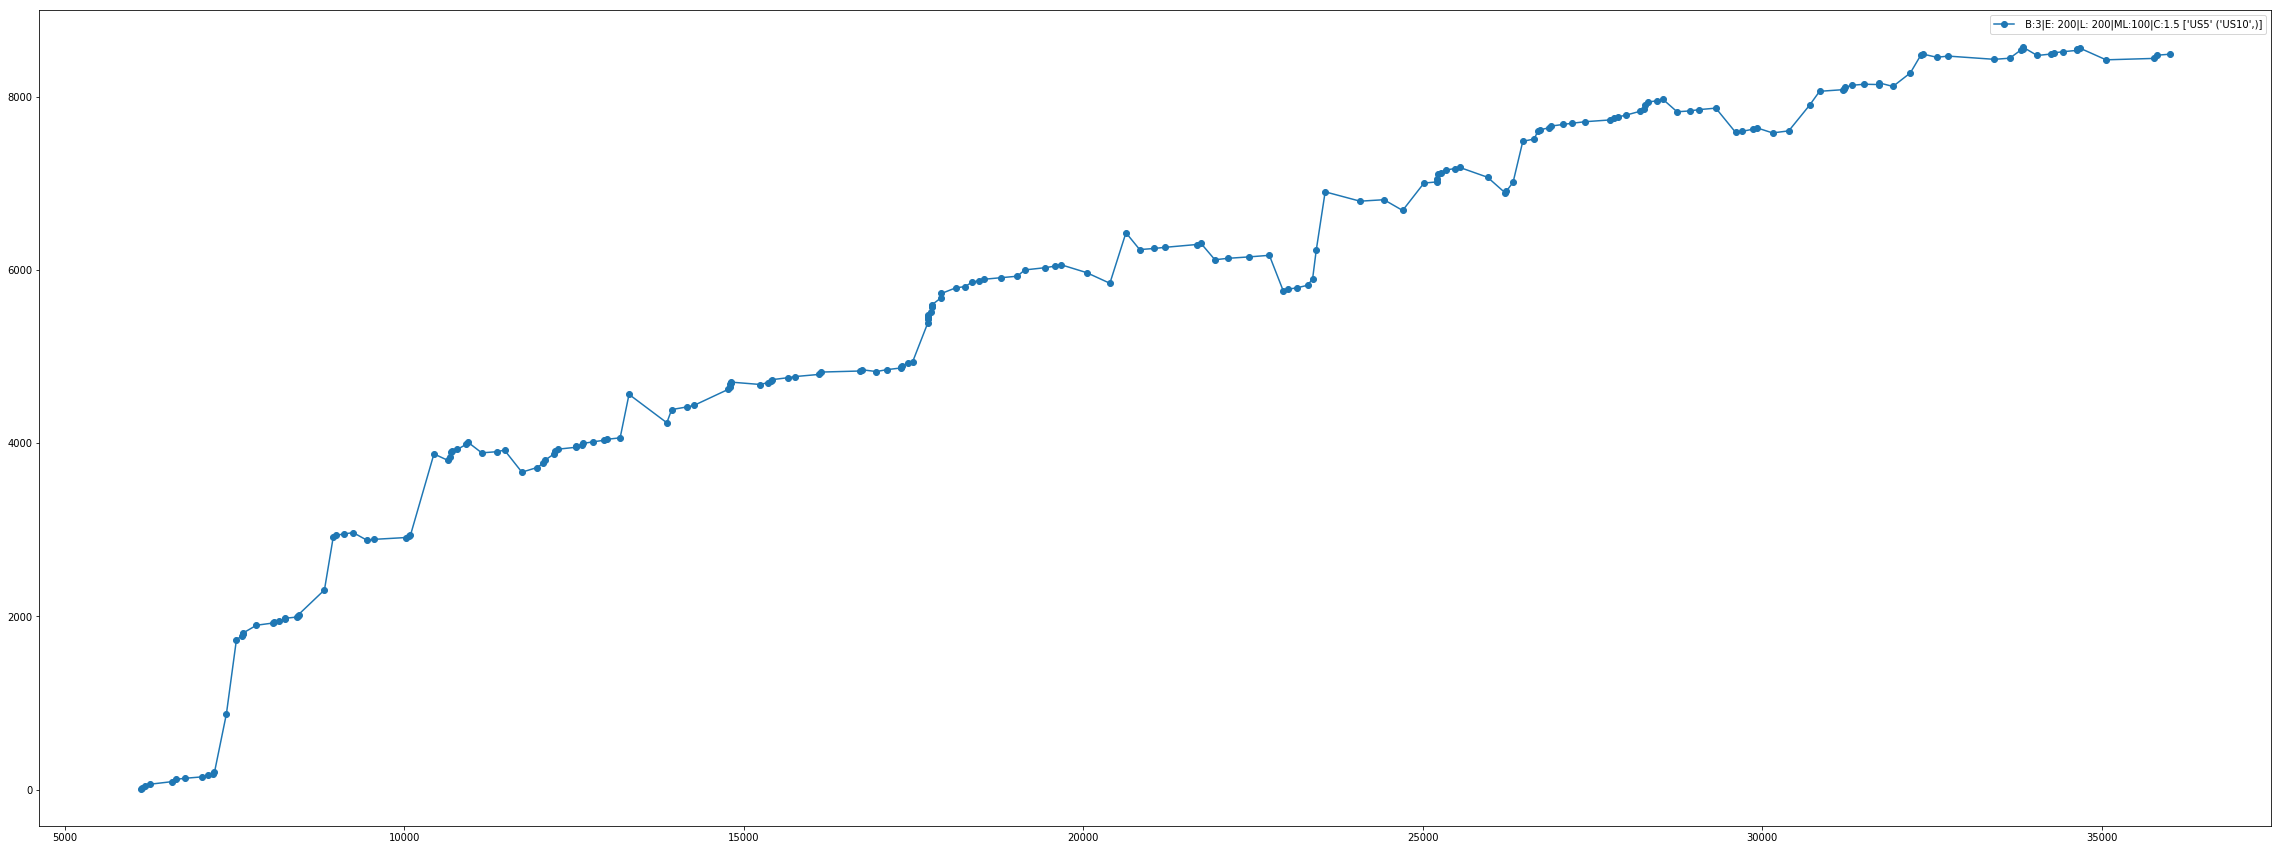

In [28]:
#Each COMBIN with different BANDWIDTHS
#GENERATE ALL COMBINATIONS
plt.figure(figsize=(40,15))
#all_ins=['US2','US10','US5','US30']
all_ins=['US5','US10']
combin_list=[]
class_list=[]
fin_list=[]

for x in range(4):
    
    [combin_list.append(x) for x in itertools.combinations(all_ins,x+1)]
    for y in combin_list:
        class_list=([x for x in all_ins if x not in y])
        
        for z in class_list:

            fin_list.append([z,y])

COMBINS=list(pd.DataFrame(fin_list).drop_duplicates().values)
print(COMBINS)


pnls_=[]
BANDWIDTHS=[x for x  in range(1,6)]
TIME_EXITS=[x*100 for x  in range(1,6)]
LOOKBACKS=[x*200 for x  in range(1,6)]
MAX_LOOPS=[x*50 for x  in range(1,5)]
COMISSION_THOLD=[x+0.5 for x in range(1,5)]

total_iter=len(BANDWIDTHS)*len(COMBINS)*len(LOOKBACKS)*len(TIME_EXITS)*len(COMISSION_THOLD)**len(MAX_LOOPS)
z=0
hg = 0
for pair in [COMBINS[1]]:

    for bnd in BANDWIDTHS[1:2]:
        for exit in TIME_EXITS[1:2]:
            for lb in LOOKBACKS[1:2]:
                for max_loop in MAX_LOOPS[1:2]:
                    for cthold in COMISSION_THOLD[1:2]:
                       #backtest(bnd=1,TIME_EXIT=200,lkbk=1000,MAX_LOOP=100,COMMS_MULTIPLIER=1)
                        #cost_dict={"US2":31.25/2+(1.6*2),"US5":31.25/4+(1.6*2),"US10":31.25/2+(1.6*2),"US30":31.25+(1.6*2)}
                        cost_dict={"US5":31.25/4+(1.6*2),"US10":31.25/2+(1.6*2)}
                        features=list((pair[1]))
                        classifier=[str(pair[0])]
                        
                        
                        bnd=3
                        exit=200
                        lb=200
                        RENEW=100
                        COM=1.5
                        
                        dates,com_pnls,sprr,pnls,labels=backtest(bnd=bnd,TIME_EXIT=exit,lkbk=lb,MAX_LOOP=RENEW,COMMS_MULTIPLIER=COM,
                            feature_list=features,classifier_list=classifier,cost_dict=cost_dict,ROLL_ENABLER=0,ENABLE_SPREAD=1,TRADING_HALT_BEFORE_ROLL=3)
                        #dates,com_pnls,sprr,pnls=backtest(1,236,288,136,1.1333257746892431)
                        
                        #plt.plot(np.cumsum(com_pnls),'-o',label="Actual Spread")
                        labels=labels + ' ' + str(pair)
                        plt.plot(dates,np.cumsum(pnls),'-o',label=labels)
                        #plt.plot(np.cumsum(com_pnls),'-o',label=labels)
                        if np.abs(np.cumsum(com_pnls)[-1])<20000: hg += np.cumsum(com_pnls)[-1]

                        print("Trades:",len(com_pnls), "Final_PL",np.cumsum(com_pnls)[-1], hg)
                        #print(sss)

                        LBB=lb
                        #dates,com_pnls,sprr,pnls,labels=backtest(bnd,int(LBB)/2,LBB,100,2,features,classifier,cost_dict,0)  
                        #plt.plot(dates,np.cumsum(pnls),label=labels)
                        #plt.plot(dates,np.cumsum(pnls),label=labels)
                        pnls_.append([dates,pnls,labels,features,classifier])
                        import pickle

                        z+=1
                        if z%100==0:
                            print("Finished:",z/total_iter)
pickle.dump( pnls_, open( "save_backtests.p", "wb" ) )                       


plt.legend()
plt.show()


In [79]:
COMBINS

[array(['US10', ('US5',)], dtype=object),
 array(['US5', ('US10',)], dtype=object)]

In [120]:
[COMBINS[21],COMBINS[4],COMBINS[5]]

[array(['US5', ('US10', 'US30')], dtype=object),
 array(['US5', ('US10',)], dtype=object),
 array(['US30', ('US10',)], dtype=object)]

In [103]:
COMBINS

[array(['US10', ('US2',)], dtype=object),
 array(['US5', ('US2',)], dtype=object),
 array(['US30', ('US2',)], dtype=object),
 array(['US2', ('US10',)], dtype=object),
 array(['US5', ('US10',)], dtype=object),
 array(['US30', ('US10',)], dtype=object),
 array(['US2', ('US5',)], dtype=object),
 array(['US10', ('US5',)], dtype=object),
 array(['US30', ('US5',)], dtype=object),
 array(['US2', ('US30',)], dtype=object),
 array(['US10', ('US30',)], dtype=object),
 array(['US5', ('US30',)], dtype=object),
 array(['US5', ('US2', 'US10')], dtype=object),
 array(['US30', ('US2', 'US10')], dtype=object),
 array(['US10', ('US2', 'US5')], dtype=object),
 array(['US30', ('US2', 'US5')], dtype=object),
 array(['US10', ('US2', 'US30')], dtype=object),
 array(['US5', ('US2', 'US30')], dtype=object),
 array(['US2', ('US10', 'US5')], dtype=object),
 array(['US30', ('US10', 'US5')], dtype=object),
 array(['US2', ('US10', 'US30')], dtype=object),
 array(['US5', ('US10', 'US30')], dtype=object),
 array(['US

In [104]:
#Each COMBIN with different BANDWIDTHS
pnls_=[]
plt.figure(figsize=(40,15))

z=0
for pair in COMBINS:

    for bnd in BANDWIDTHS:
        for exit in TIME_EXITS[1:2]:
            for lb in LOOKBACKS:
                for max_loop in MAX_LOOPS[0:1]:
                    for cthold in COMISSION_THOLD[0:1]:
                       #backtest(bnd=1,TIME_EXIT=200,lkbk=1000,MAX_LOOP=100,COMMS_MULTIPLIER=1)
                        cost_dict={"US2":31.25/2+(1.6*2),"US5":31.25/4+(1.6*2),"US10":31.25/2+(1.6*2),"US30":31.25+(1.6*2)}
                        features=list((pair[1]))
                        classifier=[str(pair[0])]
                        
                        LBB=lb
                        dates,com_pnls,sprr,pnls,labels=backtest(bnd,int(LBB)/2,LBB,100,2,features,classifier,cost_dict,1)  
                        plt.plot(dates,np.cumsum(pnls),label=labels)
                        pnls_.append([dates,pnls,labels,features,classifier])
                        
                        z+=1
                        if z%10==0:
                            print("Finished:",z/1260)
                        

plt.legend()
plt.show()
import pickle
pickle.dump( pnls_, open( "save_backtests.p", "wb" ) )

TypeError: backtest() missing 2 required positional arguments: 'ENABLE_SPREAD' and 'TRADING_HALT_BEFORE_ROLL'

In [52]:
pnls_[0][2]

IndexError: list index out of range

In [130]:
113400/28

4050.0

In [ ]:
#GET PNlS
#GET RID OF NEGATIVES AND THE ONES WITH LESS THAN 20 TRADES AND BOTTOM HALF OF SLOPE
#CALCULATE CORRLATIONS
#SELECT THE ONES WITH